<a href="https://colab.research.google.com/github/Janakrish1/OsteoCare/blob/main/OsteoCare_ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
% matplotlib inline
from PIL import Image
import cv2

import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D

import random as rnd
import math

In [ ]:
IMG_WIDTH = 32
IMG_HEIGHT = 32
IMG_CHANNELS = 1
TRAIN_SIZE = 4000 
TRAIN_PATH = '/content/drive/MyDrive/input/trainset/'
TEST_PATH = '/content/drive/MyDrive/input/testset/'
ROI_PATH = "/content/drive/MyDrive/input/roi/"

In [ ]:
def get_centers(dir_roi, resol=(2048, 2048)):
    img_id = []
    cx_pxl = []
    cy_pxl = []

    HEIGHT, WIDTH = resol
    
    # Get center coordinates of all sample images
    for dirpath, dirnames, files in os.walk(dir_roi):
        sample_id = os.path.split(dirpath)[1].split('.')[0]
        for file in files:
            img_id.append(sample_id + file[:4])
            cx_pxl.append(int(file[10:14]))
            cy_pxl.append(int(file[5:9]))

    df_roi = pd.DataFrame({'img_id': img_id,
                           'cx_pxl': cx_pxl,
                           'cy_pxl': cy_pxl},
                           columns = ['img_id', 'cx_pxl', 'cy_pxl'])
    df_roi['cx'] = df_roi.cx_pxl / float(WIDTH)
    df_roi['cy'] = df_roi.cy_pxl / float(HEIGHT)
            
    return df_roi


def coord_transfm(df_roi_org, shifts=(359, 359), cropped_resol=(1330, 1330)):
    shift_x, shift_y = shifts
    HEIGHT, WIDTH = cropped_resol
    df_roi = df_roi_org.copy()
    df_roi.cx_pxl = df_roi.cx_pxl - shift_x
    df_roi.cy_pxl = df_roi.cy_pxl - shift_y
    df_roi.cx = df_roi.cx_pxl / float(WIDTH)
    df_roi.cy = df_roi.cy_pxl / float(HEIGHT)
    
    return df_roi 


def draw_roi(img_path, img_list, true_centers, pred_centers=None, 
             actual_R=1.5, actual_imgsize=16.38, current_resol=1330, 
             org_resol=2048, rows=1, cols=3, model_name="Model"):
    
    resize_ratio = current_resol / org_resol
    R = math.floor(current_resol * actual_R/(actual_imgsize*resize_ratio))
    
    plt.figure(figsize=(8*cols, 8*rows))
    
    for i, img_id in enumerate(img_list):
        plt.subplot(rows, cols, i+1)
        img = cv2.imread(TRAIN_PATH + img_id + '.png')
        cx = math.floor(true_centers[i, 0] * current_resol)
        cy = math.floor(true_centers[i, 1] * current_resol)         
        if pred_centers is not None:
            cx_pred = math.floor(pred_centers[i, 0] * current_resol) 
            cy_pred = math.floor(pred_centers[i, 1] * current_resol)
            img_mod = cv2.circle(img, (cx_pred, cy_pred), R, (0,0,255), 3)  # Mark the predicted center in blue
            img_mod = cv2.circle(img_mod, (cx_pred, cy_pred), round(R*0.05), (0,0,255), -1)  
            img_mod = cv2.circle(img_mod, (cx, cy), R, (255,0,0), 2)  # Mark the true center in red
            img_mod = cv2.circle(img_mod, (cx, cy), round(R*0.05), (255,0,0), -1)  
        else:
            img_mod = cv2.circle(img, (cx, cy), R, (255,0,0), 3)  # Mark the true center in red
            img_mod = cv2.circle(img_mod, (cx, cy), round(R*0.05), (255,0,0), -1)  

        plt.imshow(img_mod)
        plt.savefig('/content/drive/MyDrive/input/Res50/label_overlap.png')
        if pred_centers is not None:
            plt.title("ROI center\n" + model_name + ": {}\nHuman: {}".format(str((cx_pred, cy_pred)),str((cx, cy))))
        else:
            plt.title("ROI center: {}".format(str((cx, cy))))   
            

def mirror(df_imgs, flip_axis, img_height=IMG_HEIGHT, img_width=IMG_WIDTH):
    
    pxl_cols = [col for col in df_imgs.columns if 'pxl' in col]
    num_imgs = df_imgs.shape[0]
    img_size = IMG_HEIGHT * IMG_WIDTH
    
    mat_images = df_imgs[pxl_cols].values
    mat_images = mat_images.reshape((num_imgs, IMG_HEIGHT, IMG_WIDTH))
    df_imgs_flip = df_imgs.copy()
    
    assert 'h' in flip_axis or 'v' in flip_axis, \
           "Flipping axis is not defined. Must be either 'horizontal' or 'vertical'."
    
    if 'h' in flip_axis:
        flipping = 1
        df_imgs_flip.img_id = df_imgs.img_id + 'hf'
        df_imgs_flip.cy = 1.0 - df_imgs.cy  
    elif 'v' in flip_axis:
        flipping = 2
        df_imgs_flip.img_id = df_imgs.img_id + 'vf'
        df_imgs_flip.cx = 1.0 - df_imgs.cx    
    
    # Flip images around the specified axis    
    mat_images_flip = np.flip(mat_images, flipping) \
                        .reshape((num_imgs, img_size))
    df_imgs_flip[pxl_cols] = mat_images_flip
    
    return df_imgs_flip

**Data Loading**

In [ ]:
# Read and load ROI data
df_centers_org = get_centers(ROI_PATH).sort_values(by='img_id') \
                                     .reset_index(drop=True)
print(df_centers_org.head())
df_centers = coord_transfm(df_centers_org)
print(df_centers.head())

         img_id  cx_pxl  cy_pxl        cx       cy
0  C00055300022     859    1059  0.419434  0.51709
1  C00055300023     859    1059  0.419434  0.51709
2  C00055300024     859    1059  0.419434  0.51709
3  C00055300025     859    1059  0.419434  0.51709
4  C00055300026     859    1059  0.419434  0.51709
         img_id  cx_pxl  cy_pxl       cx        cy
0  C00055300022     500     700  0.37594  0.526316
1  C00055300023     500     700  0.37594  0.526316
2  C00055300024     500     700  0.37594  0.526316
3  C00055300025     500     700  0.37594  0.526316
4  C00055300026     500     700  0.37594  0.526316


In [ ]:
# Check every image matches the ROI file
images = pd.Series(sorted(os.listdir(TRAIN_PATH)))
img_ids = images.str.split('.').str[0]

**Preprocessing of Images**

In [ ]:
# Load training images and reduce resolution
# Store all downsampled images as Numpy ndarray and Pandas dataframeimages = os.listdir(TRAIN_PATH)

img_size = IMG_HEIGHT * IMG_WIDTH
mat_images = np.zeros((TRAIN_SIZE, img_size))

# Randomly pick training samples from the trainset
train_images = images.sample(TRAIN_SIZE, random_state=10)
train_img_ids = train_images.str.split('.').str[0]

for i, file in enumerate(train_images):
    img = Image.open(TRAIN_PATH + file)
    img = img.resize((IMG_HEIGHT, IMG_WIDTH), Image.LANCZOS)
    mat_images[i] = np.asarray(img).flatten()

In [ ]:
df_train = pd.DataFrame(mat_images, 
                        columns=['pxl' + str(i) for i in range(img_size)])
df_train.insert(0, 'img_id', train_img_ids.values)
df_train = pd.merge(df_train, df_centers[['img_id', 'cx', 'cy']], 
                    on='img_id', validate="m:m")
print(df_train.head())
print(df_train.shape)

         img_id  pxl0  pxl1  pxl2  ...  pxl1022  pxl1023        cx        cy
0  C00055740055  60.0  62.0  64.0  ...     61.0     59.0  0.556391  0.366917
1  C00055410058  58.0  60.0  61.0  ...     58.0     56.0  0.387218  0.527820
2  C00056530084  63.0  65.0  66.0  ...     64.0     63.0  0.511278  0.475188
3  C00055730027  50.0  52.0  55.0  ...     50.0     48.0  0.450376  0.469173
4  C00055540039  51.0  52.0  53.0  ...     51.0     49.0  0.649624  0.508271

[5 rows x 1027 columns]
(3997, 1027)


**Manual image preprocessing**

In [ ]:
# Flip all train images around horizontal direction
df_train_hflip = mirror(df_train, 'h')

# Flip all train images around horizontal direction
df_train_vflip = mirror(df_train, 'v')

In [ ]:
# Merge original and reproduced images
df_train = pd.concat([df_train, df_train_hflip, df_train_vflip],
                     ignore_index=True)
print("New dataframe's shape: {}".format(df_train.shape))
df_centers = df_train[['img_id', 'cx', 'cy']]

New dataframe's shape: (11991, 1027)


In [ ]:
# Convert all images and their ROI centers into Numpy ndarray
X = df_train.drop(columns=['img_id', 'cx', 'cy']) \
            .values.reshape((-1, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
Y = df_train[['cx', 'cy']].values
IDs = df_train.img_id.values

# Normalization
X /= 255.0

In [ ]:
# Free RAM space
del df_train, df_train_hflip, df_train_vflip, mat_images

In [ ]:
# Split train and validation sets
X_train, X_val, Y_train, Y_val, IDs_train, IDs_val \
= train_test_split(X, Y, IDs, test_size=0.05, random_state=1)

print("Trainset shape: {}".format(X_train.shape))
print("Validateset shape: {}".format(X_val.shape))

Trainset shape: (11391, 32, 32, 1)
Validateset shape: (600, 32, 32, 1)


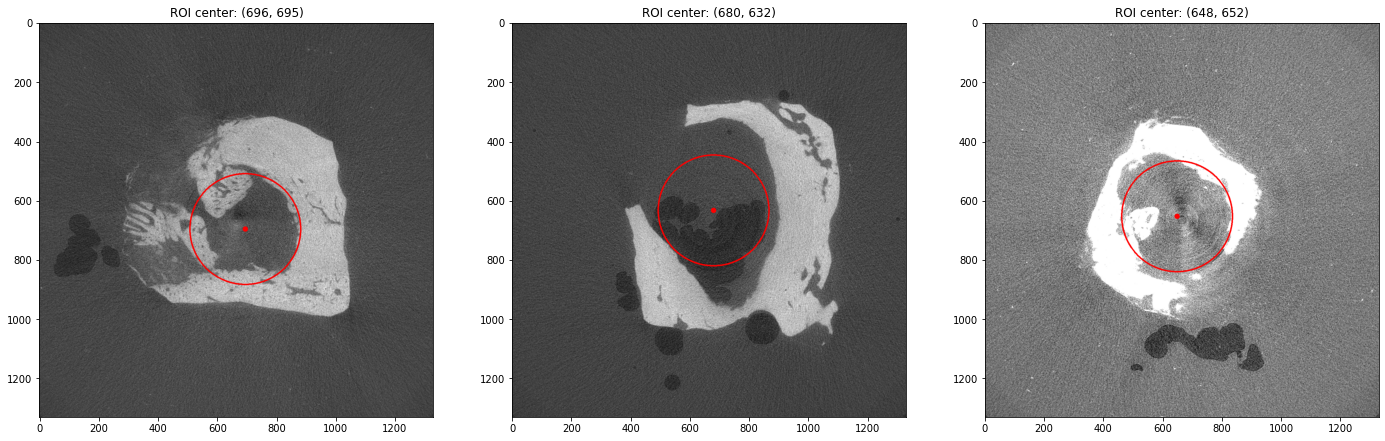

In [ ]:
# Display some sample images with known ROI
select_disp = df_centers.iloc[:TRAIN_SIZE].sample(n=3)
img_list = select_disp['img_id'].values
true_centers = select_disp[['cx', 'cy']].values
draw_roi(TRAIN_PATH, img_list, true_centers)

In [ ]:
# Define loss function
def mean_dist(y_pred, y_true):
    d = y_pred - y_true
    return tf.reduce_mean(tf.norm(d, axis=1))

**Using ResNet**

In [ ]:
# Load additional packages required for Keras implementation of ResNet
from keras import layers
from keras.layers import Input, Add, Activation, ZeroPadding2D, BatchNormalization, \
                         AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model
from keras.initializers import glorot_uniform

In [ ]:
def identity_block(X, f, filters, stage, block):
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value to later add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1,1), strides = (1,1), 
               padding = 'valid', name = conv_name_base + '2a', 
               kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    # Second component of main path
    X = Conv2D(filters = F2, kernel_size = (f,f), strides = (1,1),
               padding = 'same', name = conv_name_base + '2b',
               kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path 
    X = Conv2D(filters = F3, kernel_size = (1,1), strides = (1,1), 
               padding = 'valid', name = conv_name_base + '2c', 
               kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name = bn_name_base + '2c')(X)

    # Add shortcut value to main path, and pass it through a RELU activation 
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
   
    return X

In [ ]:
def convolutional_block(X, f, filters, stage, block, s=2):
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    # Save the input value
    X_shortcut = X

    # First component of main path 
    X = Conv2D(F1, (1,1), strides = (s,s), name = conv_name_base + '2a',
               padding = 'valid', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    # Second component of main path
    X = Conv2D(F2, (f,f), strides = (1,1), name = conv_name_base + '2b',
               padding = 'same', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(F3, (1,1), strides = (1,1), name = conv_name_base + '2c',
               padding = 'valid', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    ##### SHORTCUT PATH #### 
    X_shortcut = Conv2D(F3, (1,1), strides = (s,s), padding = 'valid',
                        name = conv_name_base + '1',
                        kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    return X

In [ ]:
def ResNet50(input_shape):
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)
    
    # Zero-Padding
    X = ZeroPadding2D((1, 1))(X_input)
    
    # Stage 1
    X = Conv2D(64, (3, 3), strides=(1, 1), name='conv1', 
               kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f=3, filters=[64, 64, 256], 
                            stage=2, block='a', s=1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    # Stage 3
    X = convolutional_block(X, f=3, filters=[128,128,512],
                            stage=3, block='a', s=2) 
    X = identity_block(X, f=3, filters=[128,128,512], stage=3, block='b')
    X = identity_block(X, f=3, filters=[128,128,512], stage=3, block='c')
    X = identity_block(X, f=3, filters=[128,128,512], stage=3, block='d')

    # Stage 4
    X = convolutional_block(X, f=3, filters=[256,256,1024],
                            stage=4, block='a', s=2) 
    X = identity_block(X, f=3, filters=[256,256,1024], stage=4, block='b')
    X = identity_block(X, f=3, filters=[256,256,1024], stage=4, block='c')
    X = identity_block(X, f=3, filters=[256,256,1024], stage=4, block='d')
    X = identity_block(X, f=3, filters=[256,256,1024], stage=4, block='e')
    X = identity_block(X, f=3, filters=[256,256,1024], stage=4, block='f')

    # Stage 5
    X = convolutional_block(X, f=3, filters=[512,512,2048],
                            stage=5, block='a', s=2) 
    X = identity_block(X, f=3, filters=[512,512,2048], stage=5, block='b')
    X = identity_block(X, f=3, filters=[512,512,2048], stage=5, block='c')

    # AVGPOOL 
    X = AveragePooling2D((2,2), name='avg_pool')(X)
    
    # output layer
    X = Flatten()(X)
    # X = Dense(1024, name='fc_1024', kernel_initializer=glorot_uniform(seed=0))(X)  # add an extra dense layer
    # X = Dense(64, name='fc_64', kernel_initializer=glorot_uniform(seed=0))(X)  # add an extra dense layer
    X = Dense(2, name='fc_outputs', kernel_initializer=glorot_uniform(seed=0))(X)
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name = 'ResNet50')

    return model

In [ ]:
# Create the model instance
ResNet_model = ResNet50(input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
ResNet_model.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 1)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 34, 34, 1)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 32, 32, 64)   640         zero_padding2d[0][0]             
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 32, 32, 64)   256         conv1[0][0]                      
___________________________________________________________________________________________

In [ ]:
# Compile the model
ResNet_model.compile(loss=mean_dist, metrics = "accuracy", optimizer='adam')
# Fit the model
history = ResNet_model.fit(X_train, Y_train, validation_split = 0.2, batch_size=128, epochs=150)

Epoch 1/150
72/72 [==============================] - 12s 96ms/step - loss: 0.1212 - accuracy: 0.8309 - val_loss: 0.1790 - val_accuracy: 0.8311
Epoch 2/150
72/72 [==============================] - 6s 85ms/step - loss: 0.0647 - accuracy: 0.8648 - val_loss: 0.7549 - val_accuracy: 0.8890
Epoch 3/150
72/72 [==============================] - 6s 85ms/step - loss: 0.0693 - accuracy: 0.8628 - val_loss: 0.0377 - val_accuracy: 0.8785
Epoch 4/150
72/72 [==============================] - 6s 85ms/step - loss: 0.0577 - accuracy: 0.8967 - val_loss: 0.0261 - val_accuracy: 0.9057
Epoch 5/150
72/72 [==============================] - 6s 86ms/step - loss: 0.0545 - accuracy: 0.8944 - val_loss: 0.1020 - val_accuracy: 0.9083
Epoch 6/150
72/72 [==============================] - 6s 86ms/step - loss: 0.0521 - accuracy: 0.8924 - val_loss: 0.5230 - val_accuracy: 0.8793
Epoch 7/150
72/72 [==============================] - 6s 85ms/step - loss: 0.0492 - accuracy: 0.9011 - val_loss: 0.0662 - val_accuracy: 0.9070
Epoch

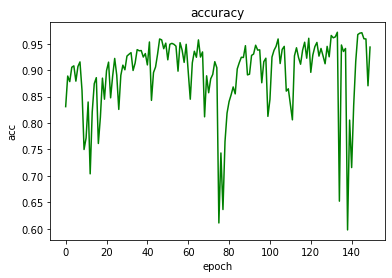

In [ ]:
plt.plot(history.history['val_accuracy'],'g')

plt.title('accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.show()

In [ ]:
ResNet_model.save('/content/drive/MyDrive/input/Res50/ResNet.h5')

In [ ]:
ResNet_model.save('/content/drive/MyDrive/input/Res50/orig/ResNet')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/input/Res50/orig/ResNet/assets


In [ ]:
# Evaluate the model with validation set
ResNet_scores_train = ResNet_model.evaluate(X_train, Y_train, batch_size=128)
print("Score on trainset: {}".format(ResNet_scores_train))

ResNet_scores_val = ResNet_model.evaluate(X_val, Y_val)
print("Score on validate set: {}".format(ResNet_scores_val))

89/89 [==============================] - 2s 24ms/step - loss: 0.0899 - accuracy: 0.9420
Score on trainset: [0.08988036215305328, 0.9419717192649841]
19/19 [==============================] - 0s 14ms/step - loss: 0.0899 - accuracy: 0.9300
Score on validate set: [0.08991842716932297, 0.9300000071525574]


In [ ]:
ResNet_pred = ResNet_model.predict(X_val, verbose=True)
ResNet_results = pd.DataFrame(np.concatenate([ResNet_pred, Y_val], axis=1), 
                              columns = ['cx_pred', 'cy_pred', 'cx', 'cy'])
ResNet_results.insert(0, 'img_id', IDs_val)
print(ResNet_results.head())

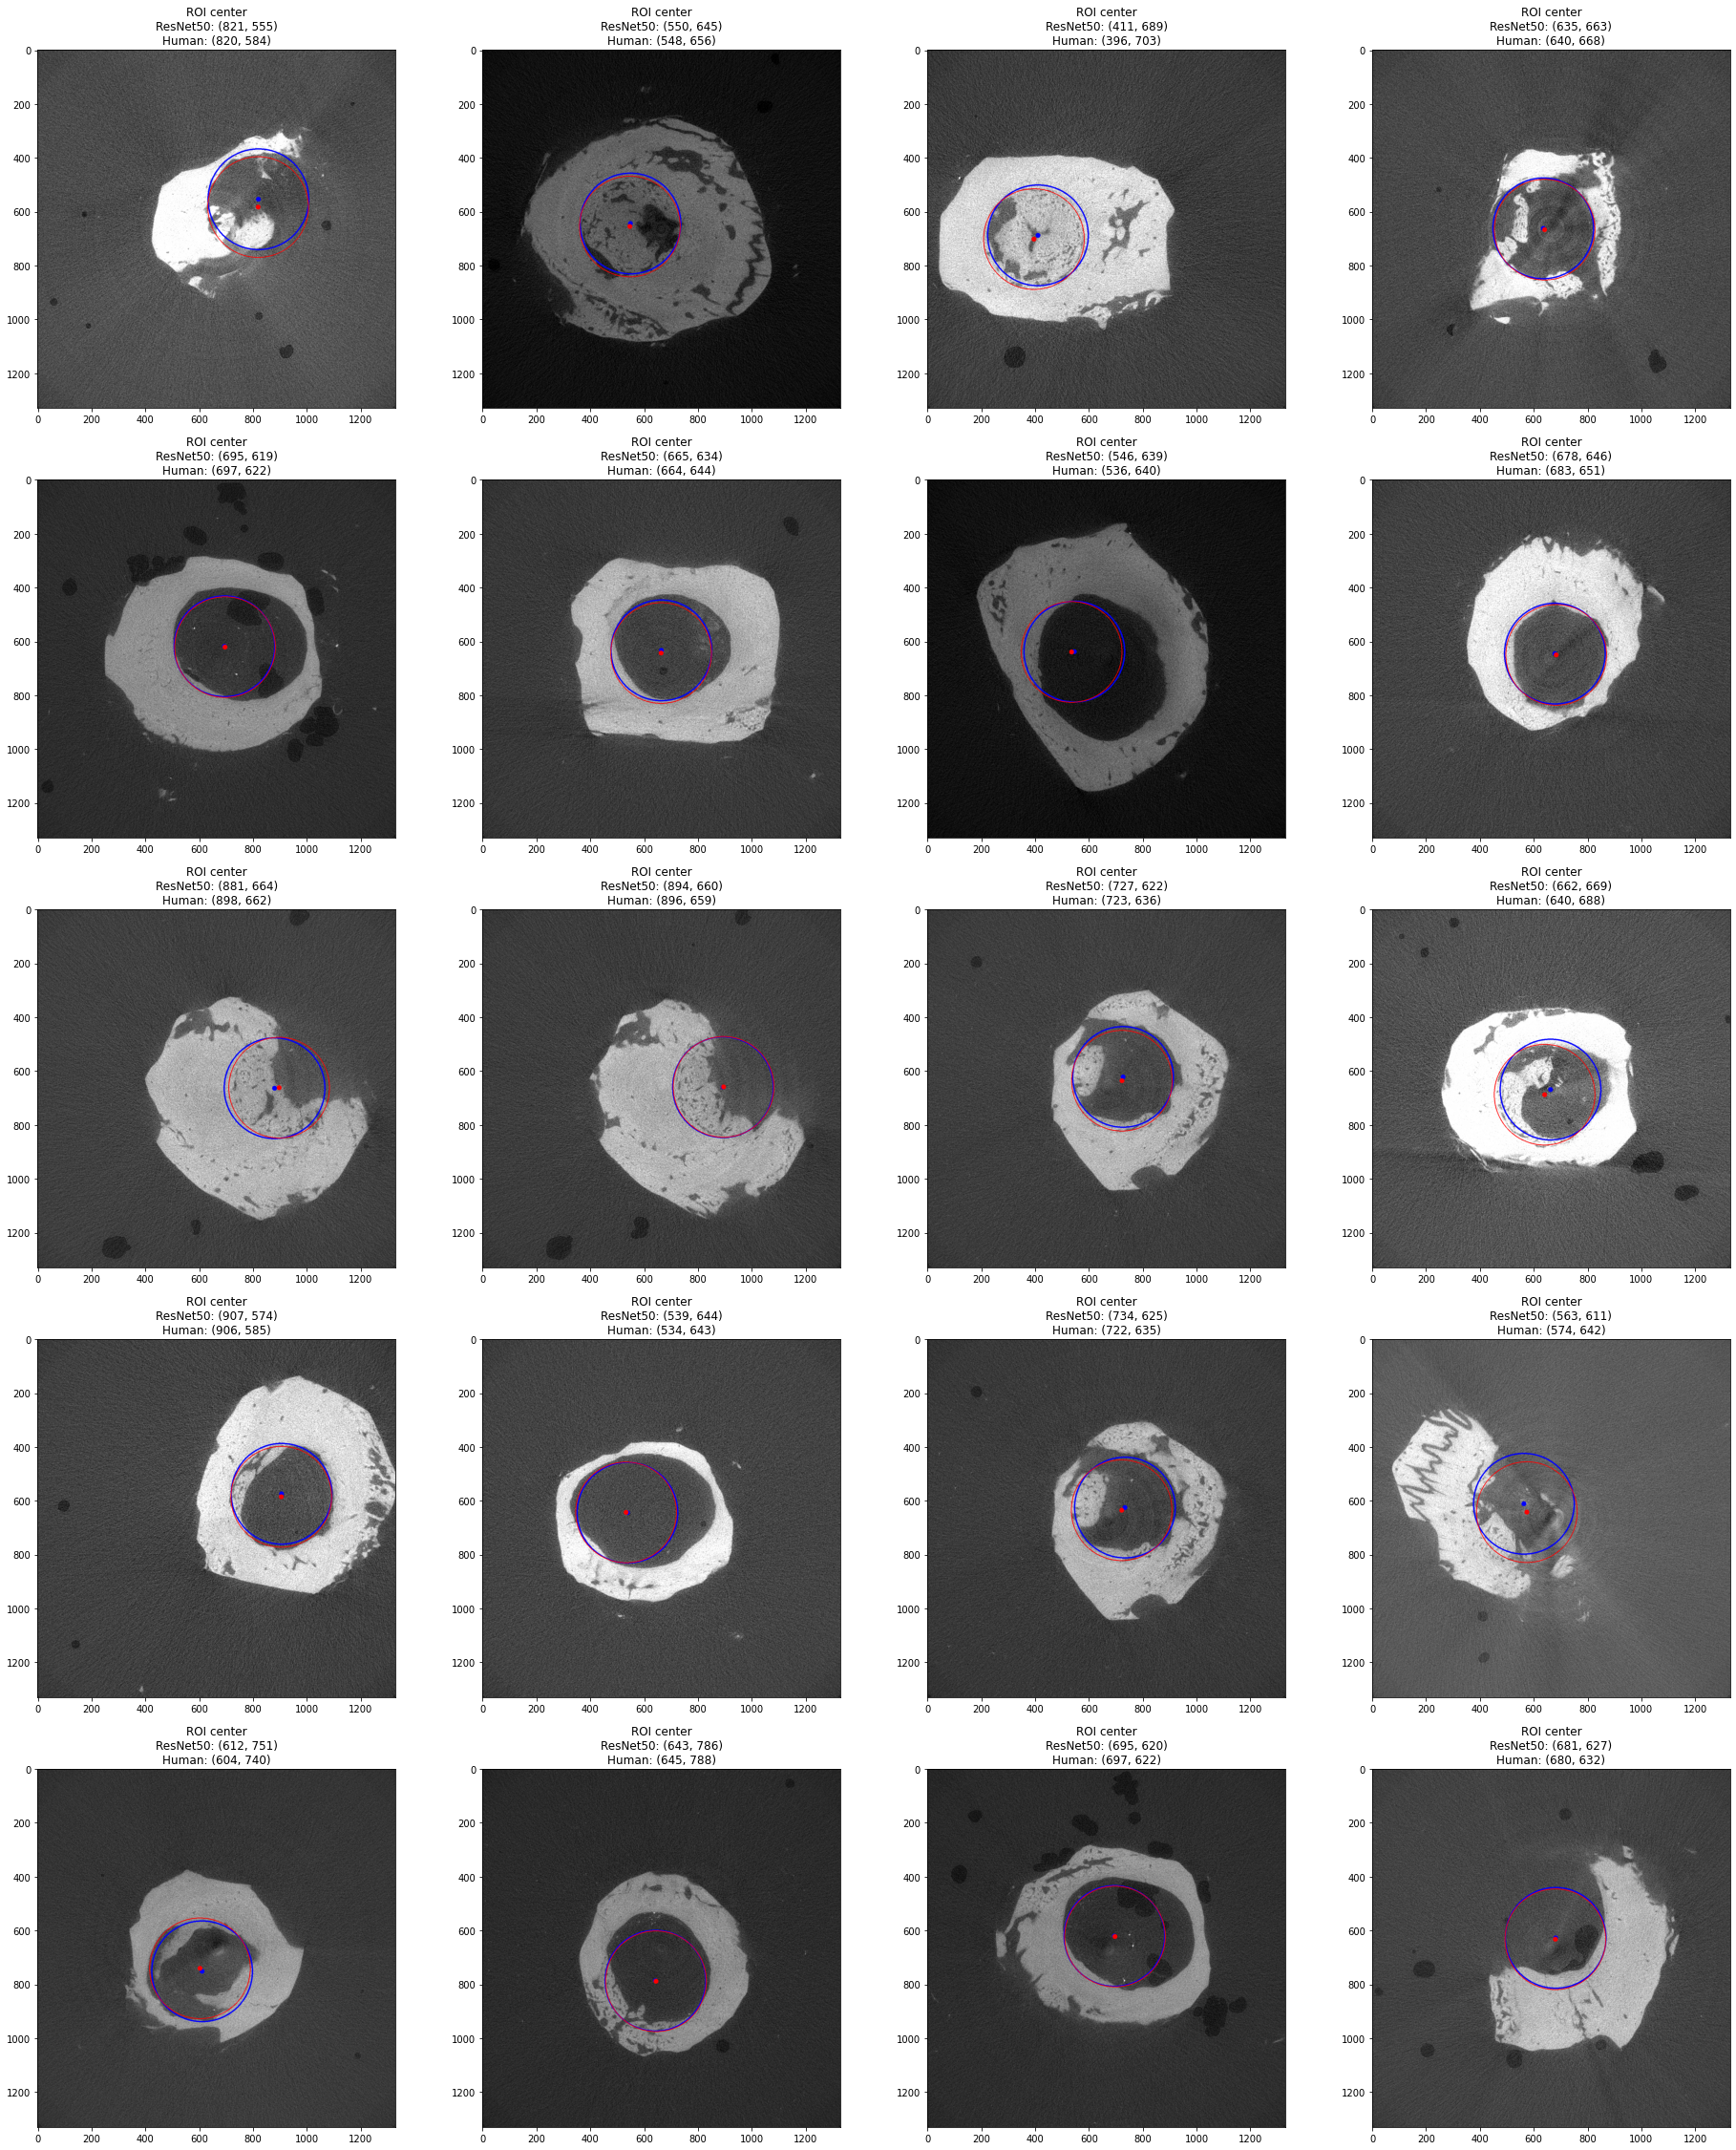

In [ ]:
orig = [img_id for img_id in ResNet_results.img_id 
        if 'f' not in img_id]
orig_imgs = ResNet_results[ResNet_results.img_id.isin(orig)]
selt_imgs = orig_imgs.sample(n=20)
img_list = selt_imgs['img_id'].values
true_centers = selt_imgs[['cx', 'cy']].values
pred_centers = selt_imgs[['cx_pred', 'cy_pred']].values

draw_roi(TRAIN_PATH, img_list, true_centers, pred_centers, 
         rows=5, cols=4, model_name="ResNet50")

In [ ]:
def draw_roi2(img_path, img_list, true_centers, pred_centers=None, 
             actual_R=1.5, actual_imgsize=16.38, current_resol=1330, 
             org_resol=2048, rows=1, cols=3, model_name="Model"):
    
    resize_ratio = current_resol / org_resol
    R = math.floor(current_resol * actual_R/(actual_imgsize*resize_ratio))
    
    plt.figure(figsize=(8*cols, 8*rows))
    
    for i, img_id in enumerate(img_list):
        plt.subplot(rows, cols, i+1)
        img = cv2.imread(TRAIN_PATH + img_id + '.png')
        cx = math.floor(true_centers[i, 0] * current_resol)
        cy = math.floor(true_centers[i, 1] * current_resol)         
        if pred_centers is not None:
            cx_pred = math.floor(pred_centers[i, 0] * current_resol) 
            cy_pred = math.floor(pred_centers[i, 1] * current_resol)
            img_mod = cv2.circle(img, (cx_pred, cy_pred), R, (0,0,255), 3)  # Mark the predicted center in blue
            img_mod = cv2.circle(img_mod, (cx_pred, cy_pred), round(R*0.05), (0,0,255), -1)   
        else:
            img_mod = cv2.circle(img, (cx, cy), R, (255,0,0), 3)  # Mark the true center in red
            img_mod = cv2.circle(img_mod, (cx, cy), round(R*0.05), (255,0,0), -1)  

        plt.imshow(img_mod)
        plt.savefig('/content/drive/MyDrive/input/Res50/label.png')
        if pred_centers is not None:
            plt.title("ROI center\n" + model_name + ": {}\nHuman: {}".format(str((cx_pred, cy_pred)),str((cx, cy))))
        else:
            plt.title("ROI center: {}".format(str((cx, cy))))

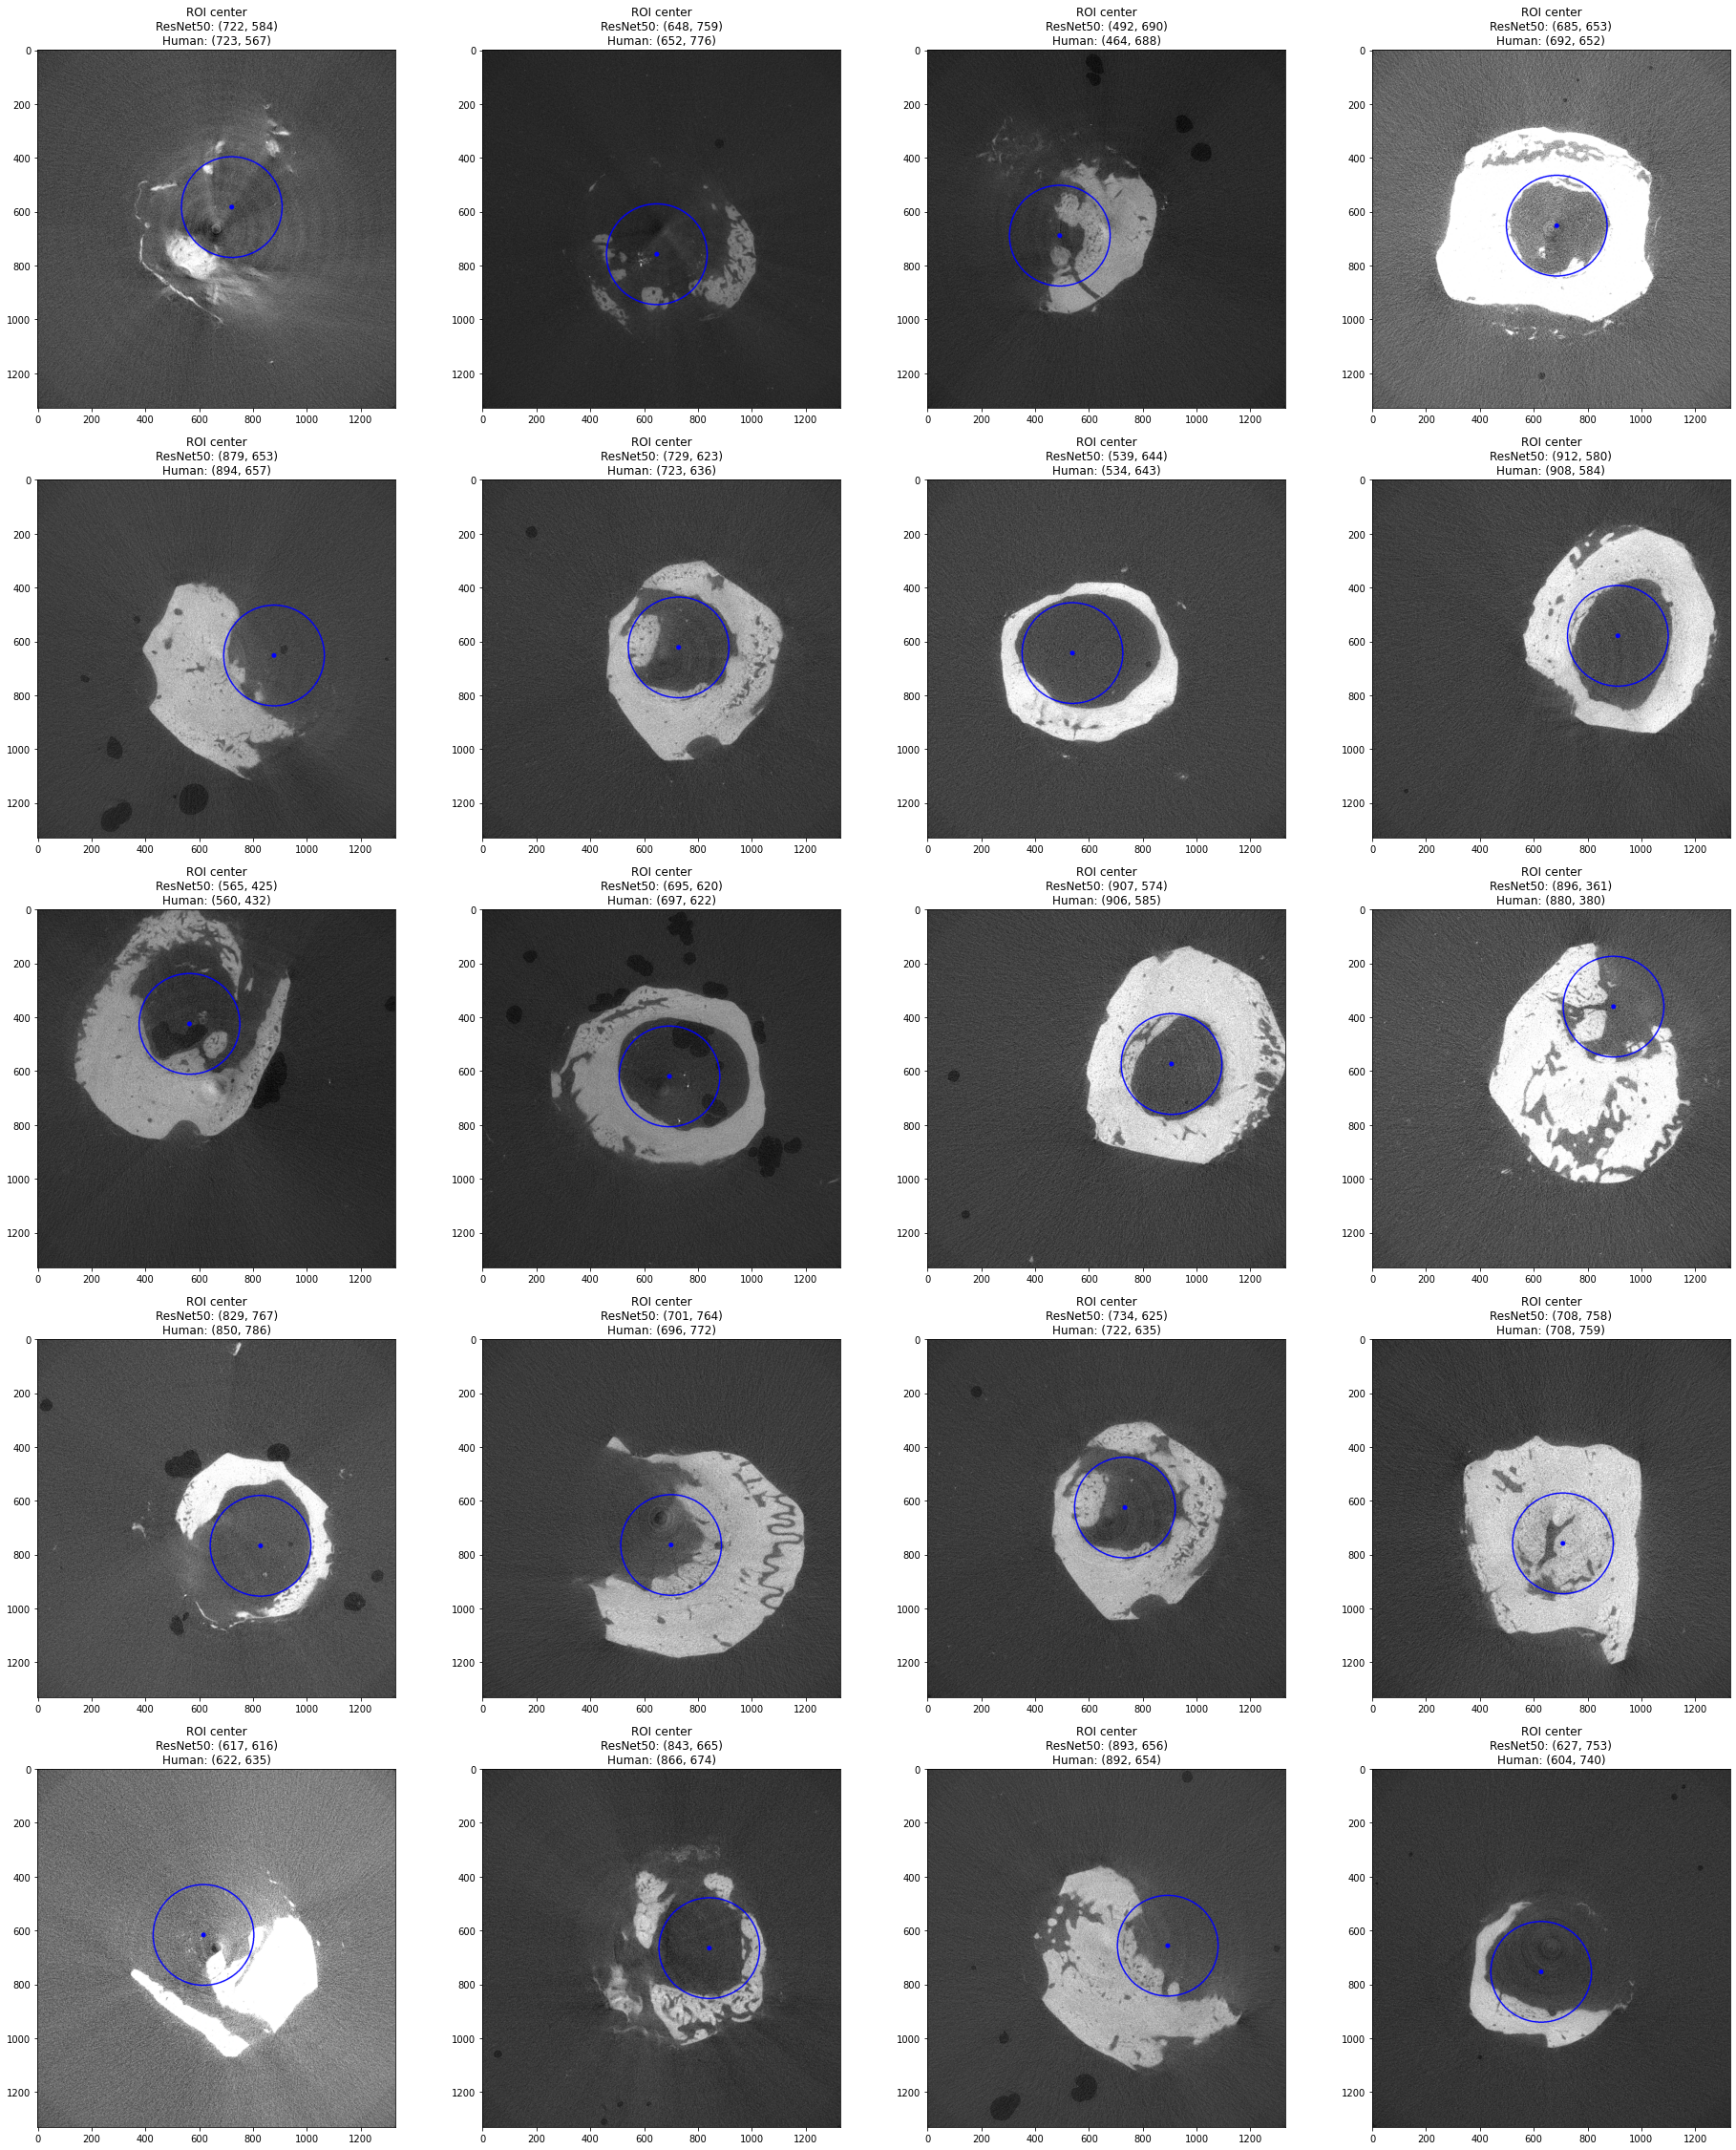

In [ ]:
orig = [img_id for img_id in ResNet_results.img_id 
        if 'f' not in img_id]
orig_imgs = ResNet_results[ResNet_results.img_id.isin(orig)]
selt_imgs = orig_imgs.sample(n=20)
img_list = selt_imgs['img_id'].values
true_centers = selt_imgs[['cx', 'cy']].values
pred_centers = selt_imgs[['cx_pred', 'cy_pred']].values

draw_roi2(TRAIN_PATH, img_list, true_centers, pred_centers, 
         rows=5, cols=4, model_name="ResNet50")

In [ ]:
# Plot the ROI centers that human determined (red) along with that model detected
selt_dots = orig_imgs.sample(n=20)
img_list = selt_dots['img_id'].values
true_centers = (selt_dots[['cx', 'cy']].values * 1330).astype(int)
pred_centers = (selt_dots[['cx_pred', 'cy_pred']].values * 1330).astype(int)

plt.figure(figsize = (5, 5))
plt.scatter(true_centers[:, 0], true_centers[:, 1], c='r', alpha=0.5, label='Human')
plt.scatter(pred_centers[:, 0], pred_centers[:, 1], c='b', alpha=0.5, label='ResNet50 model')
plt.axis('equal')
plt.legend()
plt.title("ROIs of 20 randomly selected images")
plt.show() 

In [ ]:
# Save results
ResNet_results.to_csv("/content/drive/MyDrive/input/Res501/ResNet_results.csv")